## **Dependencies**

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC 
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

from xgboost import XGBClassifier

from imblearn.combine import SMOTETomek # because our data is unbalanced

random_state = 42
np.random.seed(random_state)


## **Data Processing**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive')

Mounted at /content/drive


In [3]:
dat_nurse = pd.read_csv('./prepared_641.csv')

In [4]:
dat_nurse.head()

,HADM_ID,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,...,ROW_ID,SUBJECT_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,100571,1,100571,0.0,67,1,32.284350,1,0,0,...,656364,99008,2173-02-20,2173-02-20 06:44:00,2173-02-20 06:44:48,Nursing,Nursing Progress Note,18928.0,NaN,Hypotension (not Shock)\n Assessment:\n Hy...
1,100660,1,100660,0.0,75,1,NaN,1,0,0,...,1269150,631,2124-01-23,2124-01-23 14:03:00,2124-01-23 14:07:00,Nursing/other,Report,15597.0,NaN,Respiratory Care:\npt extubated to a 40% cool ...
2,100753,1,100753,0.0,52,2,21.788538,0,0,0,...,1270324,720,2160-05-04,2160-05-04 19:09:00,2160-05-04 19:22:00,Nursing/other,Report,15055.0,NaN,NSG ADMISSION NOTE\nMs. [**Name13 (STitle) 304...
3,100908,2,100908,0.0,89,1,28.646298,1,0,0,...,1621829,27504,2113-01-02,2113-01-02 06:31:00,2113-01-02 06:46:00,Nursing/other,Report,15746.0,NaN,ccu npn\n\n[**Age over 90 **] yr old male pmh:...
4,101197,1,101197,1.0,89,2,26.209730,0,1,0,...,1310787,3771,2190-12-12,2190-12-12 16:35:00,2190-12-12 16:37:00,Nursing/other,Report,20290.0,NaN,Respiratory Care Note\nPt received from PACU i...


In [5]:
dat_nurse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   HADM_ID                   641 non-null    int64  
 1   group                     641 non-null    int64  
 2   ID                        641 non-null    int64  
 3   outcome                   640 non-null    float64
 4   age                       641 non-null    int64  
 5   gendera                   641 non-null    int64  
 6   BMI                       514 non-null    float64
 7   hypertensive              641 non-null    int64  
 8   atrialfibrillation        641 non-null    int64  
 9   CHD with no MI            641 non-null    int64  
 10  diabetes                  641 non-null    int64  
 11  deficiencyanemias         641 non-null    int64  
 12  depression                641 non-null    int64  
 13  Hyperlipemia              641 non-null    int64  
 14  Renal fail

(array([548.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  92.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

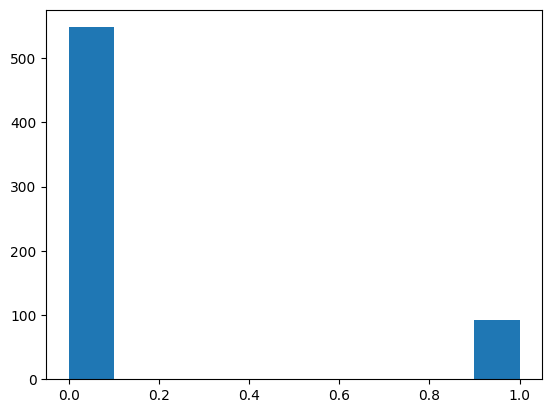

In [6]:
plt.hist(dat_nurse['outcome'])

In [7]:
# drop na (outcome na)
dat_nurse = dat_nurse[dat_nurse['outcome'].notnull()]
# train-test-split
train_dat, test_dat = train_test_split(dat_nurse, test_size = 0.15,  stratify=dat_nurse['outcome'], random_state=random_state)
# val_dat, test_dat = train_test_split(test_dat, test_size = 0.5, stratify=test_dat['outcome'], random_state=random_state)

In [8]:
# organizing data
clin_col = train_dat.columns[4:-10] # remove IDs, outcome, text
outcome_col = train_dat.columns[3]
text_col = train_dat.columns[-8:]

train_dat_clin, test_dat_clin = train_dat.loc[:, clin_col], test_dat.loc[:, clin_col]
train_dat_outcome, test_dat_outcome = train_dat.loc[:, outcome_col], test_dat.loc[:, outcome_col]
train_dat_text, test_dat_text = train_dat.loc[:, text_col], test_dat.loc[:, text_col]

In [33]:
# standardize & impute clinical
# clin_pipe = Pipeline([
#     ('scalar', StandardScaler()),
#     ('med_imputer', SimpleImputer(strategy = "median"))
# ])

# clin_pipe.fit(train_dat_clin)
# train_dat_clin_imp = clin_pipe.transform(train_dat_clin)
# val_dat_clin_imp = clin_pipe.transform(val_dat_clin)
# test_dat_clin_imp = clin_pipe.transform(test_dat_clin)

In [9]:
# tfidf
train_doc = list(train_dat['TEXT'])
# val_doc = list(val_dat['TEXT'])
test_doc = list(test_dat['TEXT'])

# tfidf_vectorizer = TfidfVectorizer(binary = True) # default l2 reg, 1-grams, binary word
# tfidf_vectorizer.fit(train_doc)
# train_dat_text_tfidf = tfidf_vectorizer.transform(train_doc).toarray()
# val_dat_text_tfidf = tfidf_vectorizer.transform(val_doc).toarray()
# test_dat_text_tfidf = tfidf_vectorizer.transform(test_doc).toarray()

In [35]:
# print(train_dat_text_tfidf.shape)
# print(train_dat_clin_imp.shape)

(544, 8842)
(544, 48)


In [24]:
# combining data together
# train_x = np.hstack([train_dat_text_tfidf])
# val_x = np.hstack([val_dat_text_tfidf])
# test_x = np.hstack([test_dat_text_tfidf])

train_y = train_dat_outcome.to_numpy()
# val_y = val_dat_outcome.to_numpy()
test_y = test_dat_outcome.to_numpy()

# https://imbalanced-learn.org/stable/combine.html
# print("train/val/test shape: ", train_x.shape, test_x.shape)#, val_x.shape, test_x.shape)

In [41]:
# # SMOTE for imbalance
# smote_tomek = SMOTETomek(random_state = random_state)
# train_x_resamp, train_y_resamp = smote_tomek.fit_resample(train_x, train_y)
# print(train_x[train_y == 0].shape, train_x[train_y == 1].shape)
# print(train_x_resamp[train_y_resamp == 0].shape, train_x_resamp[train_y_resamp == 1].shape)

(466, 8842) (78, 8842)
(466, 8842) (466, 8842)


In [46]:
# sum(train_x_resamp[0] != 0)

224

In [49]:
# sum(train_x_resamp[0] == 0)

8618

## **Pretrained Transformer**

In [10]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 95.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.1 MB/s eta 0:00:00


In [11]:
from transformers import AutoTokenizer, AutoModel
import torch

In [12]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
train_tokens = tokenizer(train_doc, padding=True, truncation=True, return_tensors="pt")

In [18]:
with torch.no_grad():
  train_outputs = model(**train_tokens)
  train_embeddings = train_outputs.last_hidden_state[:, 0, :].numpy()

In [19]:
test_tokens = tokenizer(test_doc, padding=True, truncation=True, return_tensors="pt")

In [20]:
with torch.no_grad():
  test_outputs = model(**test_tokens)
  test_embeddings = test_outputs.last_hidden_state[:, 0, :].numpy()

In [29]:
# SMOTE for imbalance
smote_tomek = SMOTETomek(random_state = random_state)
train_embeddings_resamp, train_y_resamp = smote_tomek.fit_resample(train_embeddings, train_y)
print(train_embeddings[train_y == 0].shape, train_embeddings[train_y == 1].shape)
print(train_embeddings_resamp[train_y_resamp == 0].shape, train_embeddings_resamp[train_y_resamp == 1].shape)

(466, 768) (78, 768)
(466, 768) (466, 768)


## **PCA**

In [66]:
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_20newsgroups

In [65]:
n_components = 600 # Choose the number of components to keep
pca = PCA(n_components = n_components)
train_x_pca = pca.fit_transform(train_x_resamp)

In [53]:
print("Original shape: ", train_x_resamp.shape)
print("Reduced shape: ", train_x_pca.shape)

Original shape:  (932, 8842)
Reduced shape:  (932, 100)


In [62]:
# Transform the test data using the fitted PCA model
test_x_pca = pca.transform(test_x)

## **Modelling**

In [31]:
params = {
    'LogisticRegressionCV' : {
        'penalty' : ['l2']
    },
    'SVC' : {
        'kernel' : ['linear', 'poly', 'rbf'],
        'degree' : [3, 4, 5]
    },
    'GaussianProcessClassifier' : { # https://stackoverflow.com/questions/62755556/gaussian-process-regression-hyparameter-optimisation-using-python-grid-search
            "kernel": [RBF(l) for l in np.logspace(-1, 1, 20)]
        },
    'XGBClassifier' : { # got from some towardsdatascience article i forgot
            'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
            'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
            'max_depth': [5,6,7,8,9,10,11,12,13,14],
            'n_estimators': [50,65,80,100,115,130,150],
            'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
            'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
            'eval_metric': ['auc'],
            'objective': ['binary:logistic']
    }
}

In [32]:
def fit(x, y, parameters, n_iter, random_state = 42):
    """
    Randomized hyperparameter tuning for fitting models

    parameters:
        n_iter -- number of parameter settings sampled
    """
    print("Training LogisticRegressionCV:")
    lr = LogisticRegressionCV(max_iter = int(1e6))
    rs_lr = RandomizedSearchCV(lr, parameters['LogisticRegressionCV'], n_iter = n_iter, random_state=random_state)
    rs_lr.fit(x, y) 

    print("Training SVC:")
    svc = SVC(probability = True)
    rs_svc = RandomizedSearchCV(svc, parameters['SVC'], n_iter = n_iter, random_state=random_state)
    rs_svc.fit(x, y)

    print("Training GaussianProcessClassifier:")
    gp = GaussianProcessClassifier()
    rs_gp = RandomizedSearchCV(gp, parameters['GaussianProcessClassifier'], n_iter = n_iter, random_state=random_state)
    rs_gp.fit(x, y)

    print("Training XGBClassifier:")
    xgb = XGBClassifier()
    rs_xgb = RandomizedSearchCV(xgb, parameters['XGBClassifier'], n_iter = n_iter, random_state=random_state)
    rs_xgb.fit(x, y) 

    models = [rs_lr, rs_svc, rs_gp, rs_xgb]
    return models 


In [33]:
# models = fit(train_x_resamp, train_y_resamp, params, n_iter = 20, random_state = random_state)
models = fit(train_embeddings_resamp, train_y_resamp, params, n_iter = 20, random_state = random_state)

Training LogisticRegressionCV:


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training SVC:


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training GaussianProcessClassifier:


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpc.py:477: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpc.py:477: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpc.py:477: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessin

Training XGBClassifier:


In [34]:
for model in models:
    print(model.best_estimator_, model.best_params_, model.best_score_)

LogisticRegressionCV(max_iter=1000000) {'penalty': 'l2'} 0.9131159795296417
SVC(kernel='linear', probability=True) {'kernel': 'linear', 'degree': 3} 0.9088264044620781
GaussianProcessClassifier(kernel=RBF(length_scale=0.1)) {'kernel': RBF(length_scale=0.1)} 0.8712839974699558
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=130, n_jobs=None, num_parallel_tree=None,
              predictor=None, r

In [35]:
def evaluate(x, y, models):
    scores = {
        'ACC': [], 
        'AUC': [],
        'CMAT': []
    }
    for model in models:
        y_pred = model.predict(x)
        y_proba = model.predict_proba(x)[:, 1]
        scores['ACC'].append(accuracy_score(y, y_pred))
        scores['AUC'].append(roc_auc_score(y, y_proba))
        scores['CMAT'].append(confusion_matrix(y, y_pred))
        
    return scores 

In [36]:
evaluate(test_embeddings, test_y, models)

{'ACC': [0.71875, 0.71875, 0.7083333333333334, 0.8125],
 'AUC': [0.514808362369338,
  0.5191637630662022,
  0.3954703832752613,
  0.563588850174216],
 'CMAT': [array([[65, 17],
         [10,  4]]),
  array([[65, 17],
         [10,  4]]),
  array([[65, 17],
         [11,  3]]),
  array([[77,  5],
         [13,  1]])]}

## **Viz**